In [3]:
!pip install librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import ast
import IPython
from sklearn.model_selection import GridSearchCV
from IPython.display import Audio, display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/b5/ba/c63c5786dfee4c3417094c4b00966e61e4a63efecee22cb7b4c0387dda83/librosa-0.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for audioread>=2.1.9 from https://files.pythonhosted.org/packages/57/8d/30aa32745af16af0a9a650115fbe81bde7c610ed5c21b381fca0196f3a7f/audioread-3.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for soundfile>=0.12.1 from https://files.pythonhosted.org/packages/14/e9/6b761de83277f2f02ded7e7ea6f07828ec78e4b229b80e4ca55dd205b9dc/soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata
  Obtaining dependency information for pooch>=1.1 from https://files.pythonhosted.org/packages/a8/87/77cc11c7a9ea9fd05503def69e3d18605852cd0d4b0d3b8f15bbeb3ef1d1/pooch-1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for soxr>=0.3.2 from https://files.pythonhosted.org/pac

**importing features from preprocessing notebook**

In [4]:
df = pd.read_csv('../../dataset/features.csv')

print(df.head(1))  
print('------------------------------------------------')
print(df.columns)  
print('------------------------------------------------')
print(df.dtypes)   

  Gender  Age Emotion Emotion levels  \
0   Male   51     ANG             XX   

                                     Location  \
0  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav   

                                           mfcc_mean  \
0  [-341.9889221191406, 120.79996490478516, -9.83...   

                                     mfcc_delta_mean  \
0  [0.6921295523643494, 0.4810692071914673, 0.032...   

                                    mfcc_delta2_mean  \
0  [-0.6971630454063416, -0.4661799669265747, -0....   

                                    mel_spec_db_mean  spectral_centroid_mean  \
0  [-54.73905563354492, -48.92445373535156, -41.5...             1516.157973   

   zcr_mean  
0  0.080581  
------------------------------------------------
Index(['Gender', 'Age', 'Emotion', 'Emotion levels', 'Location', 'mfcc_mean',
       'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean',
       'spectral_centroid_mean', 'zcr_mean'],
      dtype='object')
-------------------------------

In [5]:
print('na values\n', df.isna().sum())
print('------------------------------------------------')
print("number of duplicated values:\n", df.duplicated().sum())
print('------------------------------------------------')
print("shape:\n", df.shape)

na values
 Gender                    0
Age                       0
Emotion                   0
Emotion levels            0
Location                  0
mfcc_mean                 0
mfcc_delta_mean           0
mfcc_delta2_mean          0
mel_spec_db_mean          0
spectral_centroid_mean    0
zcr_mean                  0
dtype: int64
------------------------------------------------
number of duplicated values:
 0
------------------------------------------------
shape:
 (7442, 11)


In [6]:
print('Emotion level value counts\n', df['Emotion levels'].value_counts())

#dropping where emotion level is x
idx = df[df['Emotion levels'] == "X"].index
print(idx)

df = df.drop(idx)

Emotion level value counts
 Emotion levels
XX    6076
HI     455
LO     455
MD     455
X        1
Name: count, dtype: int64
Index([3212], dtype='int64')


In [7]:
df['Emotion levels'].value_counts()

#Currently, the data will remain unbalanced; later, emotion levels will be categorized as specified/unspecified

Emotion levels
XX    6076
HI     455
LO     455
MD     455
Name: count, dtype: int64

In [8]:
df['Emotion'].value_counts()

#it can be concluded that the data is approximately evenly distributed

Emotion
ANG    1271
DIS    1271
FEA    1271
HAP    1271
SAD    1270
NEU    1087
Name: count, dtype: int64

**encoding**

In [9]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

df = pd.get_dummies(df, columns=['Emotion levels'], drop_first=True)
dummy_cols = [col for col in df.columns if col.startswith('Emotion levels_')]
df[dummy_cols] = df[dummy_cols].astype(int)

emotion_mapping = {
    'ANG': 0,
    'DIS': 1,
    'FEA': 2,
    'HAP': 3,
    'SAD': 4,
    'NEU': 5
}

df['emotion_numeric'] = df['Emotion'].map(emotion_mapping)


print(df.head())


   Gender  Age Emotion                                    Location  \
0       1   51     ANG  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav   
1       1   51     DIS  ../../dataset/AudioWAV/1001_DFA_DIS_XX.wav   
2       1   51     FEA  ../../dataset/AudioWAV/1001_DFA_FEA_XX.wav   
3       1   51     HAP  ../../dataset/AudioWAV/1001_DFA_HAP_XX.wav   
4       1   51     NEU  ../../dataset/AudioWAV/1001_DFA_NEU_XX.wav   

                                           mfcc_mean  \
0  [-341.9889221191406, 120.79996490478516, -9.83...   
1  [-388.4619445800781, 133.88211059570312, -17.7...   
2  [-352.20843505859375, 115.79106903076172, -3.4...   
3  [-337.8395690917969, 120.10960388183594, -12.6...   
4  [-368.1755676269531, 124.36493682861328, -4.64...   

                                     mfcc_delta_mean  \
0  [0.6921295523643494, 0.4810692071914673, 0.032...   
1  [0.08185644447803497, 0.11408255249261856, -0....   
2  [-0.008709535002708435, -0.020871829241514206,...   
3  [-0.06729506701

In [10]:
print(df.loc[1])

Gender                                                                    1
Age                                                                      51
Emotion                                                                 DIS
Location                         ../../dataset/AudioWAV/1001_DFA_DIS_XX.wav
mfcc_mean                 [-388.4619445800781, 133.88211059570312, -17.7...
mfcc_delta_mean           [0.08185644447803497, 0.11408255249261856, -0....
mfcc_delta2_mean          [-0.18879133462905884, -0.041042305529117584, ...
mel_spec_db_mean          [-44.846012115478516, -38.46656799316406, -29....
spectral_centroid_mean                                          1457.589671
zcr_mean                                                           0.069094
Emotion levels_LO                                                         0
Emotion levels_MD                                                         0
Emotion levels_XX                                                         1
emotion_nume

In [11]:
#dropping the 'emotion' column, since we included dummy variables
df = df.drop(columns=['Emotion'])

In [12]:
print(df.dtypes)

Gender                      int64
Age                         int64
Location                   object
mfcc_mean                  object
mfcc_delta_mean            object
mfcc_delta2_mean           object
mel_spec_db_mean           object
spectral_centroid_mean    float64
zcr_mean                  float64
Emotion levels_LO           int32
Emotion levels_MD           int32
Emotion levels_XX           int32
emotion_numeric             int64
dtype: object


In [13]:
#expanding columns that contain lists as values
list_columns = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean']

for col in list_columns:
    if col not in df.columns:
        print(f"skipping {col}, not found")
        continue
    
    print(f"\nworking on: {col}")
    
    # sting -> list
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # num -> list (if num is somewhere)
    df[col] = df[col].apply(lambda x: [x] if isinstance(x, (float, int)) else x)
        
    # max list lenght in the column
    max_len = df[col].apply(len).max()
    
    # filling lists with zeros if neccessary
    df[col] = df[col].apply(lambda x: x + [0]*(max_len - len(x)))
    
    #expanding the df
    expanded = pd.DataFrame(df[col].tolist(), index=df.index)
    expanded.columns = [f'{col}_{i}' for i in range(max_len)]
    
    #dropping org columns
    df = df.drop(columns=[col])
    df = pd.concat([df, expanded], axis=1)
    
    print(f"expanding {max_len} new columns.")

print("\nall columns edited properly")



working on: mfcc_mean
expanding 20 new columns.

working on: mfcc_delta_mean
expanding 20 new columns.

working on: mfcc_delta2_mean
expanding 20 new columns.

working on: mel_spec_db_mean
expanding 128 new columns.

all columns edited properly


In [14]:
print(df.loc[0])

Gender                                                             1
Age                                                               51
Location                  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
spectral_centroid_mean                                   1516.157973
zcr_mean                                                    0.080581
                                             ...                    
mel_spec_db_mean_123                                           -80.0
mel_spec_db_mean_124                                           -80.0
mel_spec_db_mean_125                                           -80.0
mel_spec_db_mean_126                                           -80.0
mel_spec_db_mean_127                                           -80.0
Name: 0, Length: 197, dtype: object


In [15]:
print(df.dtypes)

Gender                      int64
Age                         int64
Location                   object
spectral_centroid_mean    float64
zcr_mean                  float64
                           ...   
mel_spec_db_mean_123      float64
mel_spec_db_mean_124      float64
mel_spec_db_mean_125      float64
mel_spec_db_mean_126      float64
mel_spec_db_mean_127      float64
Length: 197, dtype: object


Standardization

In [16]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

#numeric_cols will be predicted -> no standardization
numeric_cols = numeric_cols.drop('emotion_numeric') if 'emotion_numeric' in numeric_cols else numeric_cols

print("cols for standardization:", list(numeric_cols))

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\ndata after the standardization process:")
print(df[numeric_cols].head())

cols for standardization: ['Gender', 'Age', 'spectral_centroid_mean', 'zcr_mean', 'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 'mfcc_mean_19', 'mfcc_delta_mean_0', 'mfcc_delta_mean_1', 'mfcc_delta_mean_2', 'mfcc_delta_mean_3', 'mfcc_delta_mean_4', 'mfcc_delta_mean_5', 'mfcc_delta_mean_6', 'mfcc_delta_mean_7', 'mfcc_delta_mean_8', 'mfcc_delta_mean_9', 'mfcc_delta_mean_10', 'mfcc_delta_mean_11', 'mfcc_delta_mean_12', 'mfcc_delta_mean_13', 'mfcc_delta_mean_14', 'mfcc_delta_mean_15', 'mfcc_delta_mean_16', 'mfcc_delta_mean_17', 'mfcc_delta_mean_18', 'mfcc_delta_mean_19', 'mfcc_delta2_mean_0', 'mfcc_delta2_mean_1', 'mfcc_delta2_mean_2', 'mfcc_delta2_mean_3', 'mfcc_delta2_mean_4', 'mfcc_delta2_mean_5', 'mfcc_delta2_mean_6', 'mfcc_delta2_mean_7', 'm

In [17]:
print(df.loc[0])

Gender                                                      0.945445
Age                                                         1.102698
Location                  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
spectral_centroid_mean                                      0.491062
zcr_mean                                                    0.725741
                                             ...                    
mel_spec_db_mean_123                                       -0.029498
mel_spec_db_mean_124                                       -0.029116
mel_spec_db_mean_125                                       -0.028836
mel_spec_db_mean_126                                       -0.028654
mel_spec_db_mean_127                                       -0.028541
Name: 0, Length: 197, dtype: object


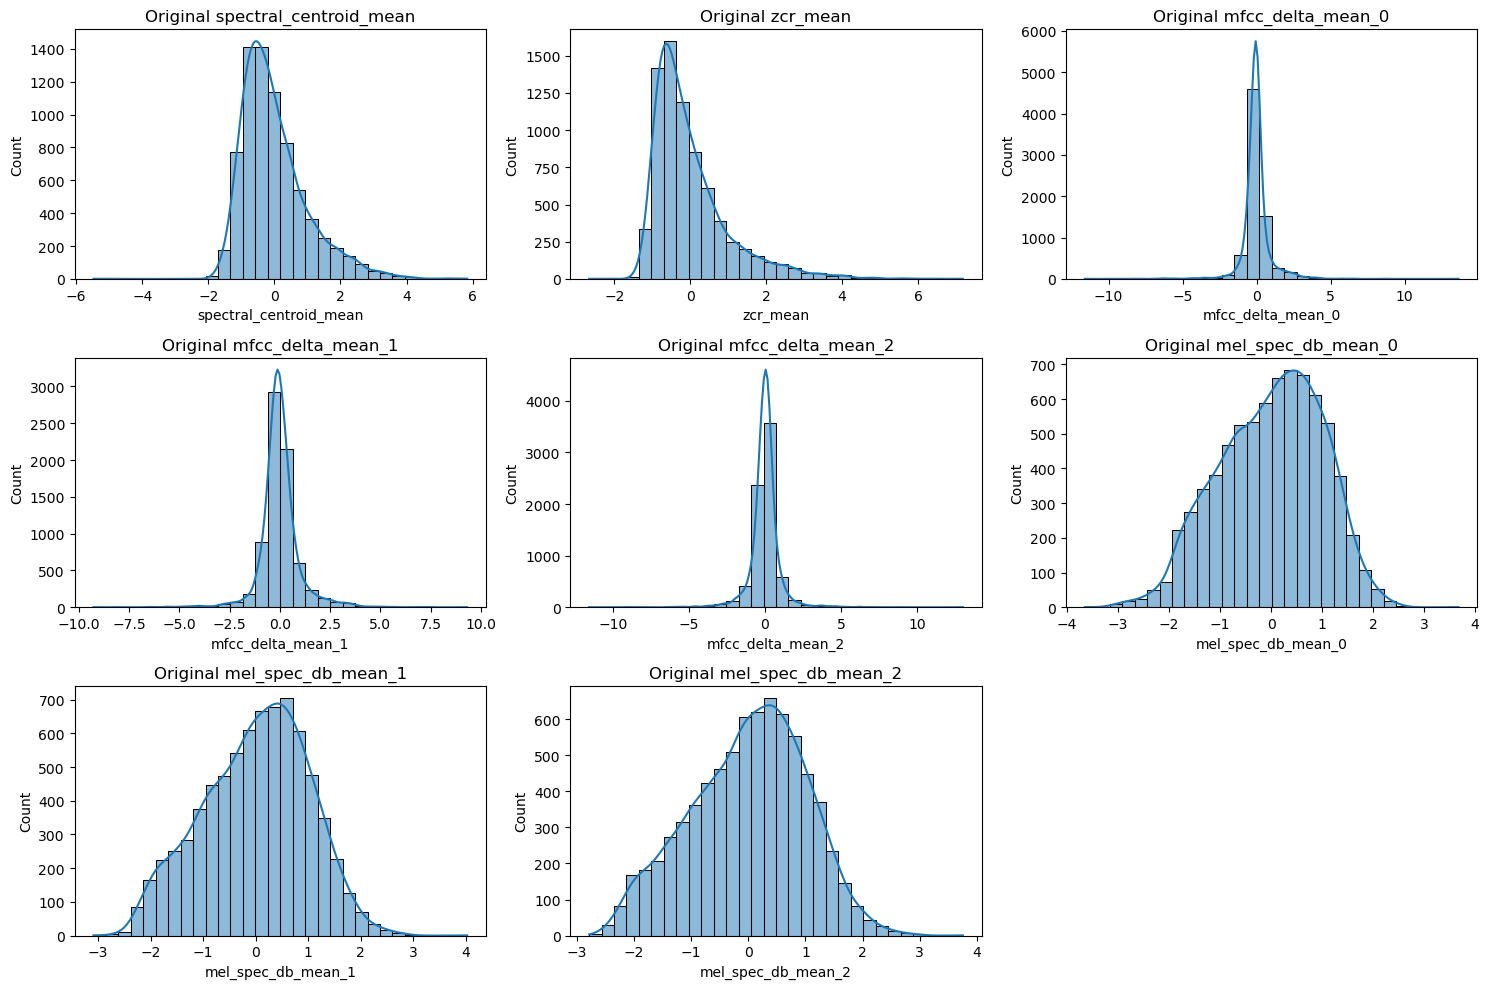

In [18]:
feature_cols = ['spectral_centroid_mean', 'zcr_mean'] + \
               [f'mfcc_delta_mean_{i}' for i in range(3)] + \
               [f'mel_spec_db_mean_{i}' for i in range(3)]

plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Original {col}')
plt.tight_layout()
plt.show()

In [19]:
#unnecessary column 'location'
df = df.drop(columns=['Location'])

In [20]:
X = df.drop(columns=['emotion_numeric'])
y = df['emotion_numeric']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200, 220, 250, 270, 300, 305, 310, 320],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


#Best parameters: {'n_estimators': 310}
#Best cross-validation score: 0.4450619139343395
#Test Accuracy: 0.4432505036937542

In [22]:
# Random Forest
rf1 = RandomForestClassifier(n_estimators=310, random_state=42)
rf1.fit(X_train, y_train)

# Evaluation
y_pred = rf1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4432505036937542

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.71      0.65       254
           1       0.42      0.27      0.33       254
           2       0.37      0.22      0.28       255
           3       0.36      0.37      0.37       254
           4       0.47      0.63      0.54       254
           5       0.37      0.45      0.41       218

    accuracy                           0.44      1489
   macro avg       0.43      0.44      0.43      1489
weighted avg       0.43      0.44      0.43      1489



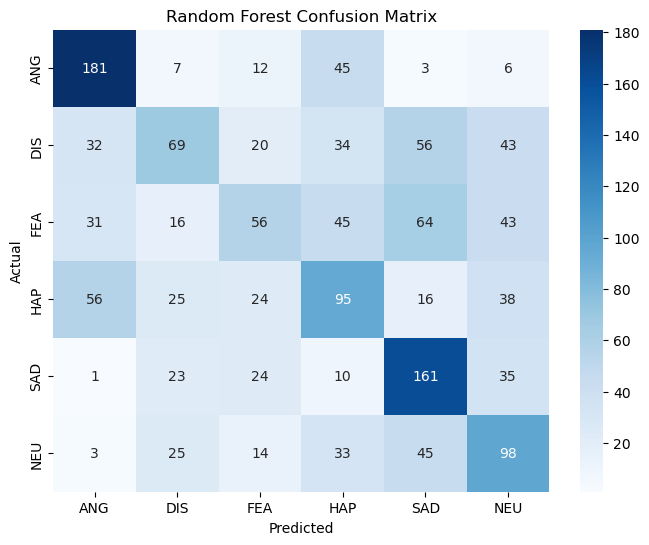

In [23]:
cmrf1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmrf1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [24]:
nb_model1 = GaussianNB()
nb_model1.fit(X_train, y_train)

y_pred = nb_model1.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))

accuracy: 0.3082605775688381
classification report:
               precision    recall  f1-score   support

           0       0.35      0.70      0.47       254
           1       0.21      0.06      0.09       254
           2       0.20      0.00      0.01       255
           3       0.37      0.10      0.16       254
           4       0.44      0.26      0.33       254
           5       0.25      0.79      0.38       218

    accuracy                           0.31      1489
   macro avg       0.30      0.32      0.24      1489
weighted avg       0.31      0.31      0.24      1489



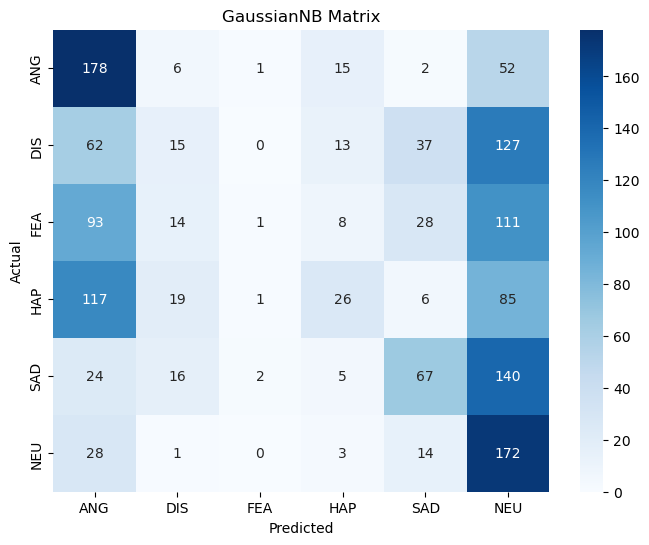

In [29]:
cmnb1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmnb1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GaussianNB Matrix")
plt.show()

Epoch 1/50


C:\Users\milic\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2751 - loss: 1.7598 - val_accuracy: 0.3533 - val_loss: 1.5082
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3583 - loss: 1.5483 - val_accuracy: 0.3929 - val_loss: 1.4629
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3715 - loss: 1.4819 - val_accuracy: 0.4030 - val_loss: 1.4523
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3888 - loss: 1.4642 - val_accuracy: 0.4090 - val_loss: 1.4447
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4121 - loss: 1.4222 - val_accuracy: 0.4244 - val_loss: 1.4329
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4173 - loss: 1.4100 - val_accuracy: 0.4298 - val_loss: 1.4190
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4363 - loss: 1.3856 - val_accuracy: 0.4265 - val_loss: 1.4155
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4463 - loss: 1.3545 - val_accuracy: 0.4365 - val_

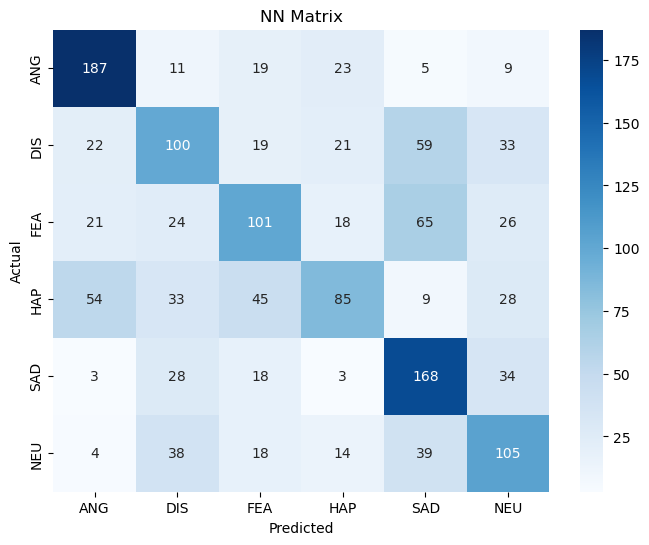

In [35]:
input_dim = X_train.shape[1]  

model1 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
)

y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nclassification report:\n")
print(classification_report(y_test, y_pred_classes))


cmnn1 = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cmnn1, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NN Matrix")
plt.show()


In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10, 15],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']  
}

svc = SVC()

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_svc = grid_search.best_estimator_
y_pred_svm = best_svc.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc1 = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()


#Best parameters: {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}
#Best cross-validation score: 0.48437892033387664
#Test Accuracy: 0.5023505708529215

Accuracy: 0.4983210208193418
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       254
           1       0.40      0.40      0.40       254
           2       0.44      0.38      0.41       255
           3       0.52      0.44      0.47       254
           4       0.50      0.59      0.54       254
           5       0.44      0.46      0.45       218

    accuracy                           0.50      1489
   macro avg       0.49      0.50      0.49      1489
weighted avg       0.50      0.50      0.50      1489



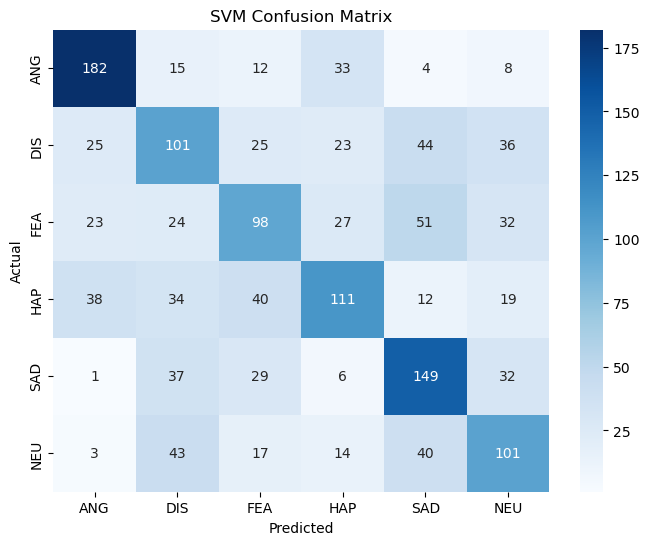

In [36]:
svm_model1 = SVC(kernel='rbf', C=15, gamma=0.001)
svm_model1.fit(X_train, y_train)

y_pred_svm = svm_model1.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc1 = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

LDA

In [48]:
lda = LinearDiscriminantAnalysis(n_components=4)
lda.fit(X_train, y_train)
X_train_r = lda.transform(X_train)
X_test_r = lda.transform(X_test)

print(X_train_r.shape)
print(X_test_r.shape)

(5952, 4)
(1489, 4)


In [49]:
# Random Forest
rf1LDA = RandomForestClassifier(n_estimators=310, random_state=42)
rf1LDA.fit(X_train_r, y_train)

# Evaluation
y_pred = rf1LDA.predict(X_test_r)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.45533915379449297

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.68       254
           1       0.35      0.33      0.34       254
           2       0.42      0.38      0.40       255
           3       0.38      0.35      0.36       254
           4       0.50      0.55      0.52       254
           5       0.38      0.43      0.40       218

    accuracy                           0.46      1489
   macro avg       0.45      0.45      0.45      1489
weighted avg       0.45      0.46      0.45      1489



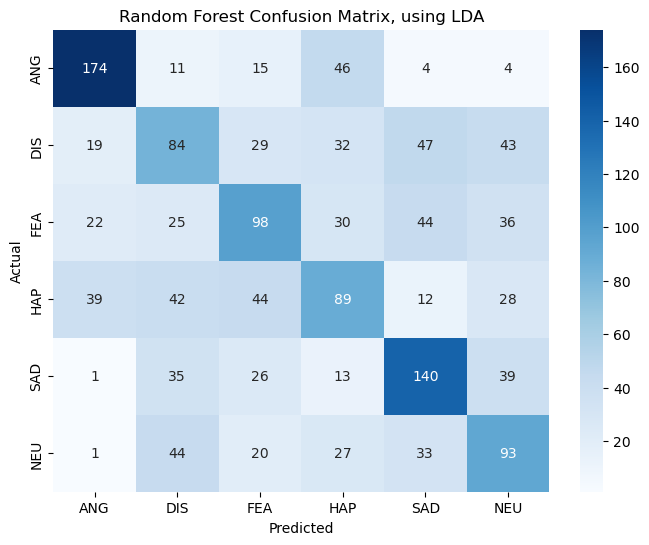

In [51]:
cmrf1LDA = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmrf1LDA, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix, using LDA")
plt.show()

In [52]:
nb_model1LDA = GaussianNB()
nb_model1LDA.fit(X_train_r, y_train)

y_pred = nb_model1LDA.predict(X_test_r)

print("accuracy:", accuracy_score(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))

accuracy: 0.4922766957689725
classification report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       254
           1       0.40      0.32      0.36       254
           2       0.47      0.35      0.40       255
           3       0.46      0.42      0.44       254
           4       0.51      0.64      0.57       254
           5       0.39      0.55      0.45       218

    accuracy                           0.49      1489
   macro avg       0.49      0.49      0.49      1489
weighted avg       0.49      0.49      0.49      1489



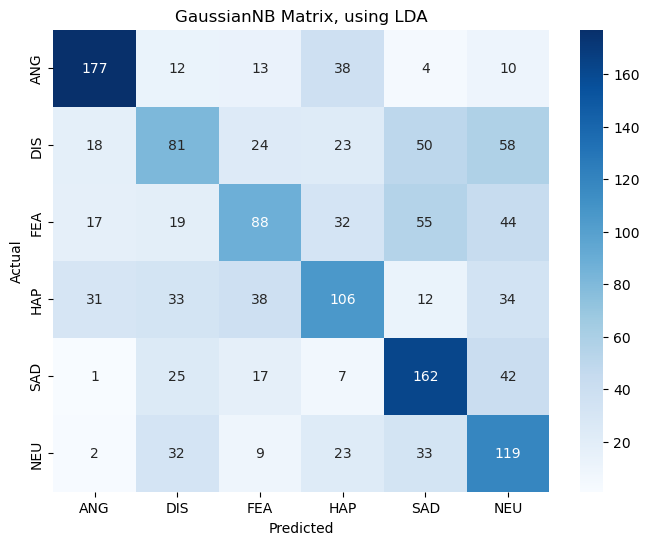

In [54]:
cmnb1LDA = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmnb1LDA, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GaussianNB Matrix, using LDA")
plt.show()

Epoch 1/50


C:\Users\milic\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3575 - loss: 1.5522 - val_accuracy: 0.4762 - val_loss: 1.3245
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4917 - loss: 1.2883 - val_accuracy: 0.4849 - val_loss: 1.3068
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4903 - loss: 1.2824 - val_accuracy: 0.4815 - val_loss: 1.3059
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4950 - loss: 1.2659 - val_accuracy: 0.4849 - val_loss: 1.3136
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5035 - loss: 1.2508 - val_accuracy: 0.4936 - val_loss: 1.3096
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078 - loss: 1.2403 - val_accuracy: 0.4849 - val_loss: 1.3058
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4953 - loss: 1.2520 - val_accuracy: 0.4835 - val_loss: 1.3071
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5121 - loss: 1.2341 - val_accuracy: 0.4829 - val_

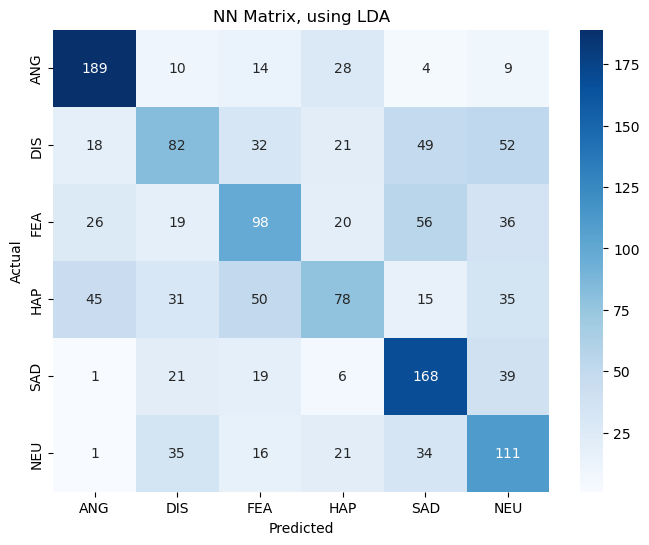

In [56]:
input_dim = X_train_r.shape[1]  

model1LDA = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])

model1LDA.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model1LDA.fit(
    X_train_r, y_train,
    validation_data=(X_test_r, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
)

y_pred = model1LDA.predict(X_test_r)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nclassification report:\n")
print(classification_report(y_test, y_pred_classes))


cmnn1LDA = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cmnn1LDA, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NN Matrix, using LDA")
plt.show()


Accuracy: 0.48757555406312963
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       254
           1       0.41      0.37      0.39       254
           2       0.40      0.39      0.39       255
           3       0.44      0.39      0.41       254
           4       0.54      0.61      0.58       254
           5       0.39      0.44      0.42       218

    accuracy                           0.49      1489
   macro avg       0.48      0.49      0.48      1489
weighted avg       0.49      0.49      0.49      1489



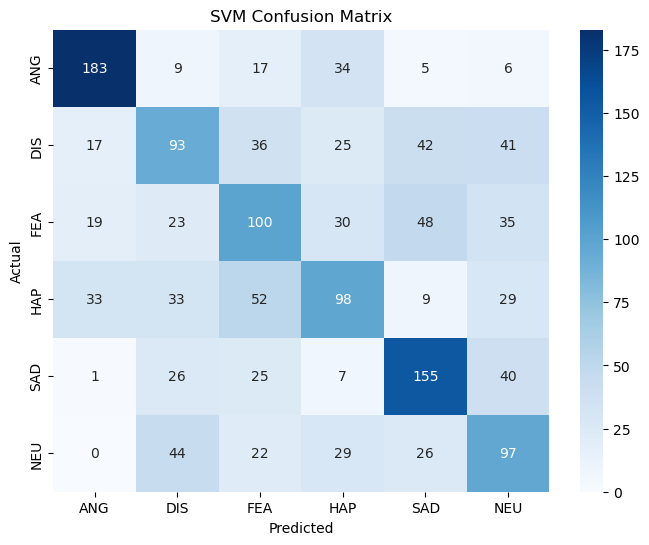

In [57]:
svm_model1LDA = SVC(kernel='rbf', C=15, gamma=0.001)
svm_model1LDA.fit(X_train_r, y_train)

y_pred_svm = svm_model1LDA.predict(X_test_r)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc1LDA = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc1LDA, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

In the next segment, different data will be used — columns where the values were lists will be modified so that their value is the average of the list, as there is a possibility that dimensionality affects the model’s results. Models of the same architecture will be trained on such data, and then I will attempt to find the optimal parameters.

In [58]:
df = pd.read_csv('../../dataset/features.csv')

idx = df[df['Emotion levels'] == "X"].index
print(idx)

df = df.drop(idx)

Index([3212], dtype='int64')


In [59]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df = pd.get_dummies(df, columns=['Emotion levels'], drop_first=True)
dummy_cols = [col for col in df.columns if col.startswith('Emotion levels_')]

df[dummy_cols] = df[dummy_cols].astype(int)


emotion_mapping = {
    'ANG': 0,
    'DIS': 1,
    'FEA': 2,
    'HAP': 3,
    'SAD': 4,
    'NEU': 5
}

df['emotion_numeric'] = df['Emotion'].map(emotion_mapping)


print(df.head())

   Gender  Age Emotion                                    Location  \
0       1   51     ANG  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav   
1       1   51     DIS  ../../dataset/AudioWAV/1001_DFA_DIS_XX.wav   
2       1   51     FEA  ../../dataset/AudioWAV/1001_DFA_FEA_XX.wav   
3       1   51     HAP  ../../dataset/AudioWAV/1001_DFA_HAP_XX.wav   
4       1   51     NEU  ../../dataset/AudioWAV/1001_DFA_NEU_XX.wav   

                                           mfcc_mean  \
0  [-341.9889221191406, 120.79996490478516, -9.83...   
1  [-388.4619445800781, 133.88211059570312, -17.7...   
2  [-352.20843505859375, 115.79106903076172, -3.4...   
3  [-337.8395690917969, 120.10960388183594, -12.6...   
4  [-368.1755676269531, 124.36493682861328, -4.64...   

                                     mfcc_delta_mean  \
0  [0.6921295523643494, 0.4810692071914673, 0.032...   
1  [0.08185644447803497, 0.11408255249261856, -0....   
2  [-0.008709535002708435, -0.020871829241514206,...   
3  [-0.06729506701

In [60]:
df = df.drop(columns=['Emotion'])

In [61]:
df.loc[0]

Gender                                                                    1
Age                                                                      51
Location                         ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
mfcc_mean                 [-341.9889221191406, 120.79996490478516, -9.83...
mfcc_delta_mean           [0.6921295523643494, 0.4810692071914673, 0.032...
mfcc_delta2_mean          [-0.6971630454063416, -0.4661799669265747, -0....
mel_spec_db_mean          [-54.73905563354492, -48.92445373535156, -41.5...
spectral_centroid_mean                                          1516.157973
zcr_mean                                                           0.080581
Emotion levels_LO                                                         0
Emotion levels_MD                                                         0
Emotion levels_XX                                                         1
emotion_numeric                                                           0
Name: 0, dty

In [62]:
#all cols thah contain lists: replace the list with the list's mean value
list_columns = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean']

for col in list_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


for col in list_columns:
    df[col] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else 0)

In [63]:
df.loc[0]

Gender                                                             1
Age                                                               51
Location                  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
mfcc_mean                                                 -13.598056
mfcc_delta_mean                                             0.055392
mfcc_delta2_mean                                           -0.054704
mel_spec_db_mean                                          -55.341329
spectral_centroid_mean                                   1516.157973
zcr_mean                                                    0.080581
Emotion levels_LO                                                  0
Emotion levels_MD                                                  0
Emotion levels_XX                                                  1
emotion_numeric                                                    0
Name: 0, dtype: object

In [64]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

numeric_cols = numeric_cols.drop('emotion_numeric') if 'emotion_numeric' in numeric_cols else numeric_cols

print("cols for standardization:", list(numeric_cols))

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\ndata after the standardization process:")
print(df[numeric_cols].head())

cols for standardization: ['Gender', 'Age', 'mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean', 'spectral_centroid_mean', 'zcr_mean']

data after the standardization process:
     Gender       Age  mfcc_mean  mfcc_delta_mean  mfcc_delta2_mean  \
0  0.945445  1.102698  -1.343910         2.993967         -3.426461   
1  0.945445  1.102698  -1.816883        -0.227654         -0.412230   
2  0.945445  1.102698  -1.760424         0.510616          0.022484   
3  0.945445  1.102698  -1.652316        -0.769750          1.202826   
4  0.945445  1.102698  -1.269239         0.743748          2.118731   

   mel_spec_db_mean  spectral_centroid_mean  zcr_mean  
0         -0.557317                0.491062  0.725741  
1          0.789949                0.260493  0.242048  
2         -1.363802                0.119985 -0.024465  
3         -0.677227                0.355777  0.023015  
4         -1.013972                0.129042 -0.075807  


In [65]:
df = df.drop(columns=['Location'])

In [66]:
X = df.drop(columns=['emotion_numeric'])
y = df['emotion_numeric']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
# Random Forest
rf2 = RandomForestClassifier(n_estimators=310, random_state=42)
rf2.fit(X_train, y_train)

# Evaluation
y_pred = rf2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.38415043653458697

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.68      0.61       254
           1       0.25      0.20      0.23       254
           2       0.30      0.18      0.22       255
           3       0.31      0.29      0.30       254
           4       0.45      0.51      0.48       254
           5       0.35      0.45      0.40       218

    accuracy                           0.38      1489
   macro avg       0.37      0.39      0.37      1489
weighted avg       0.37      0.38      0.37      1489



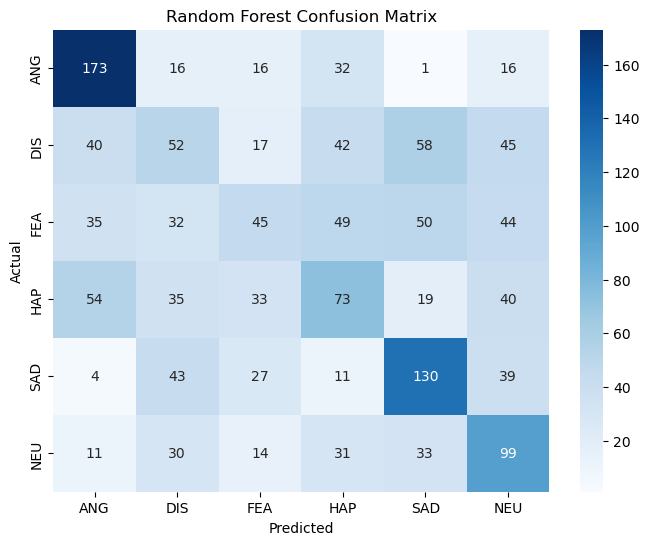

In [69]:
cmrf2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmrf2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [70]:
nb_model2 = GaussianNB()
nb_model2.fit(X_train, y_train)

y_pred = nb_model2.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))

accuracy: 0.20953660174613833
classification report:
               precision    recall  f1-score   support

           0       0.41      0.11      0.17       254
           1       0.36      0.02      0.03       254
           2       0.16      0.04      0.06       255
           3       0.27      0.03      0.06       254
           4       0.42      0.17      0.25       254
           5       0.18      1.00      0.31       218

    accuracy                           0.21      1489
   macro avg       0.30      0.23      0.15      1489
weighted avg       0.30      0.21      0.14      1489



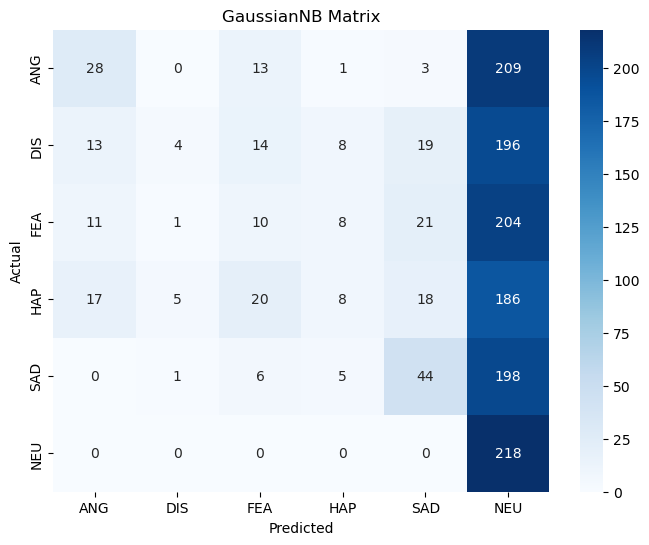

In [71]:
cmnb2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmnb2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GaussianNB Matrix")
plt.show()

Epoch 1/50


C:\Users\milic\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2722 - loss: 1.6984 - val_accuracy: 0.3365 - val_loss: 1.5437
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3310 - loss: 1.5851 - val_accuracy: 0.3761 - val_loss: 1.5156
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3696 - loss: 1.5307 - val_accuracy: 0.3875 - val_loss: 1.5011
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3605 - loss: 1.5172 - val_accuracy: 0.3808 - val_loss: 1.4962
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3669 - loss: 1.5122 - val_accuracy: 0.3895 - val_loss: 1.4819
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3734 - loss: 1.5081 - val_accuracy: 0.3855 - val_loss: 1.4854
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3752 - loss: 1.4774 - val_accuracy: 0.3929 - val_loss: 1.4783
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3754 - loss: 1.4844 - val_accuracy: 0.3741 - val_

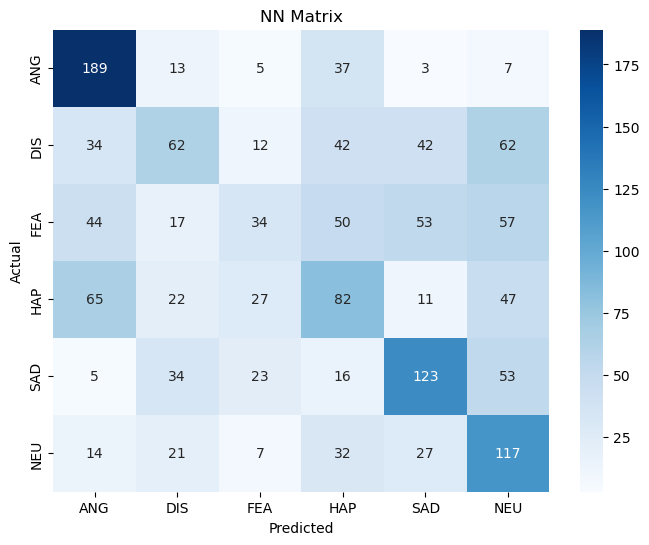

In [73]:
input_dim = X_train.shape[1]  

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nclassification report:\n")
print(classification_report(y_test, y_pred_classes))


cmnn2 = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cmnn2, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NN Matrix")
plt.show()


Accuracy: 0.3794492948287441
              precision    recall  f1-score   support

           0       0.50      0.68      0.57       254
           1       0.26      0.13      0.17       254
           2       0.23      0.13      0.17       255
           3       0.33      0.33      0.33       254
           4       0.42      0.61      0.50       254
           5       0.34      0.41      0.37       218

    accuracy                           0.38      1489
   macro avg       0.35      0.38      0.35      1489
weighted avg       0.35      0.38      0.35      1489



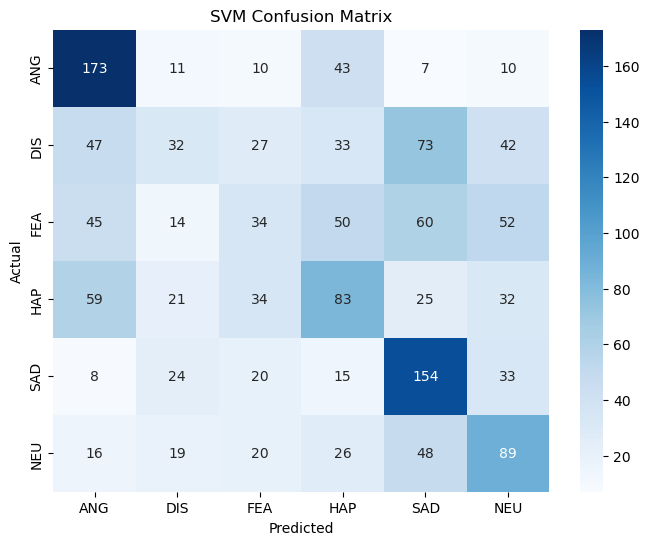

In [74]:
svm_model2 = SVC(kernel='rbf', C=15, gamma=0.001)
svm_model2.fit(X_train, y_train)

y_pred_svm = svm_model2.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc2 = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

Comparing results

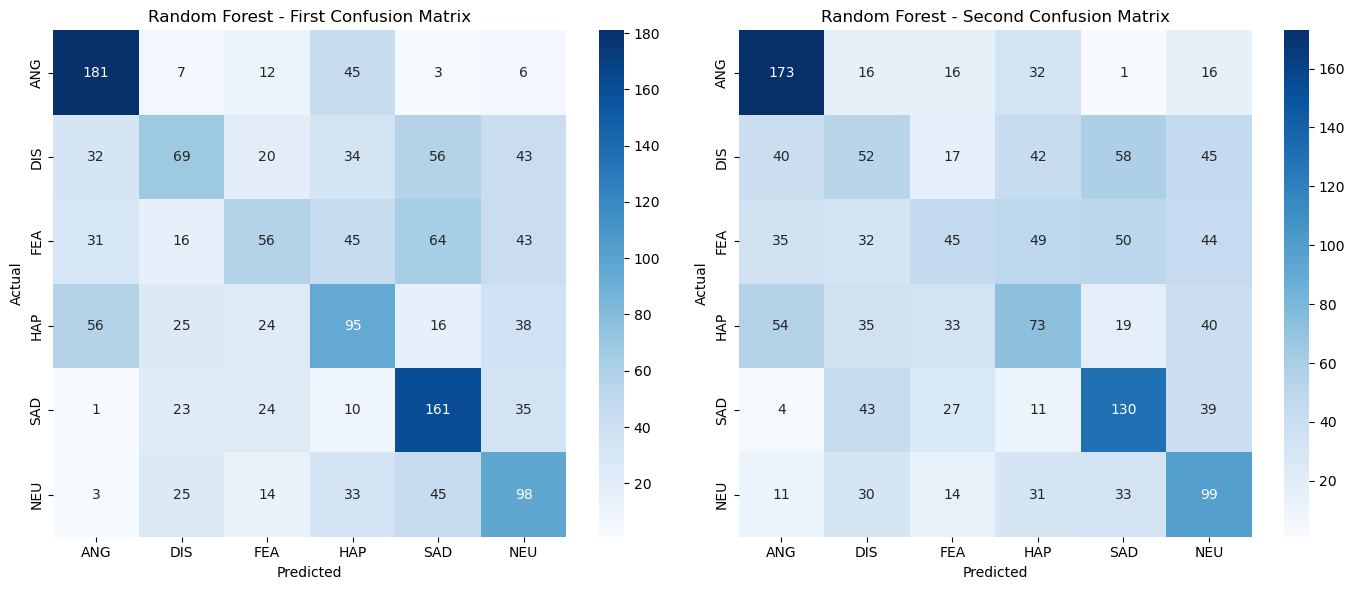

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmrf1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Random Forest - First Confusion Matrix")

sns.heatmap(cmrf2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Random Forest - Second Confusion Matrix")

plt.tight_layout()
plt.show()


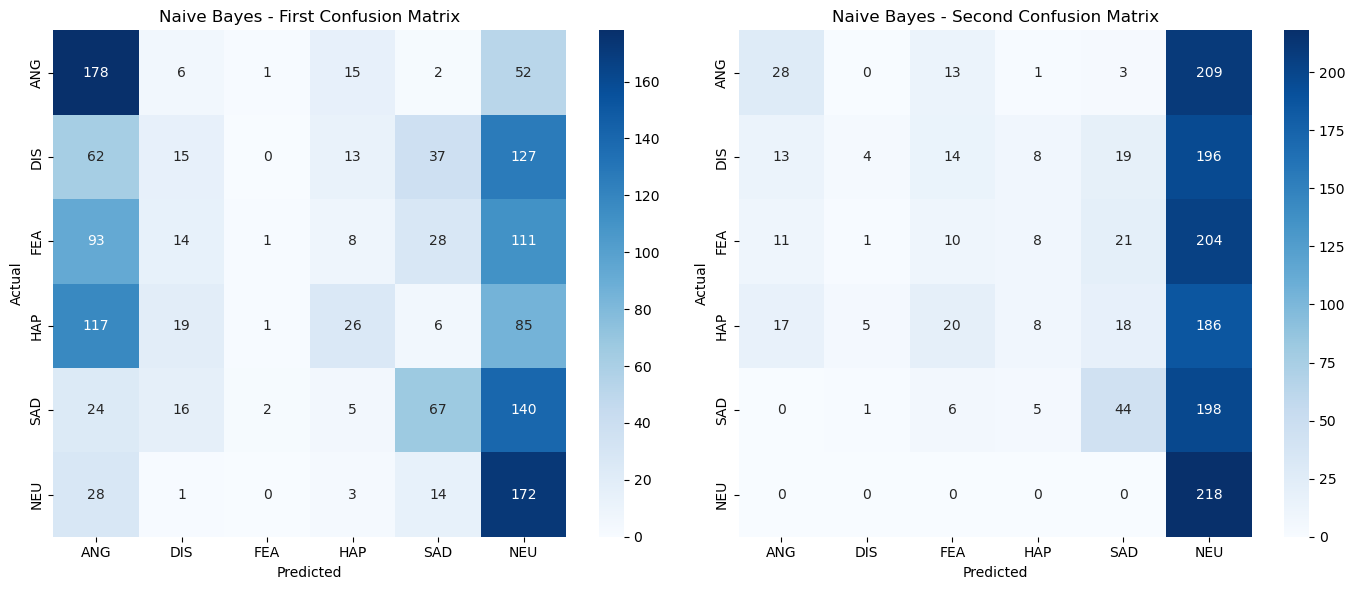

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmnb1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Naive Bayes - First Confusion Matrix")

sns.heatmap(cmnb2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Naive Bayes - Second Confusion Matrix")

plt.tight_layout()
plt.show()

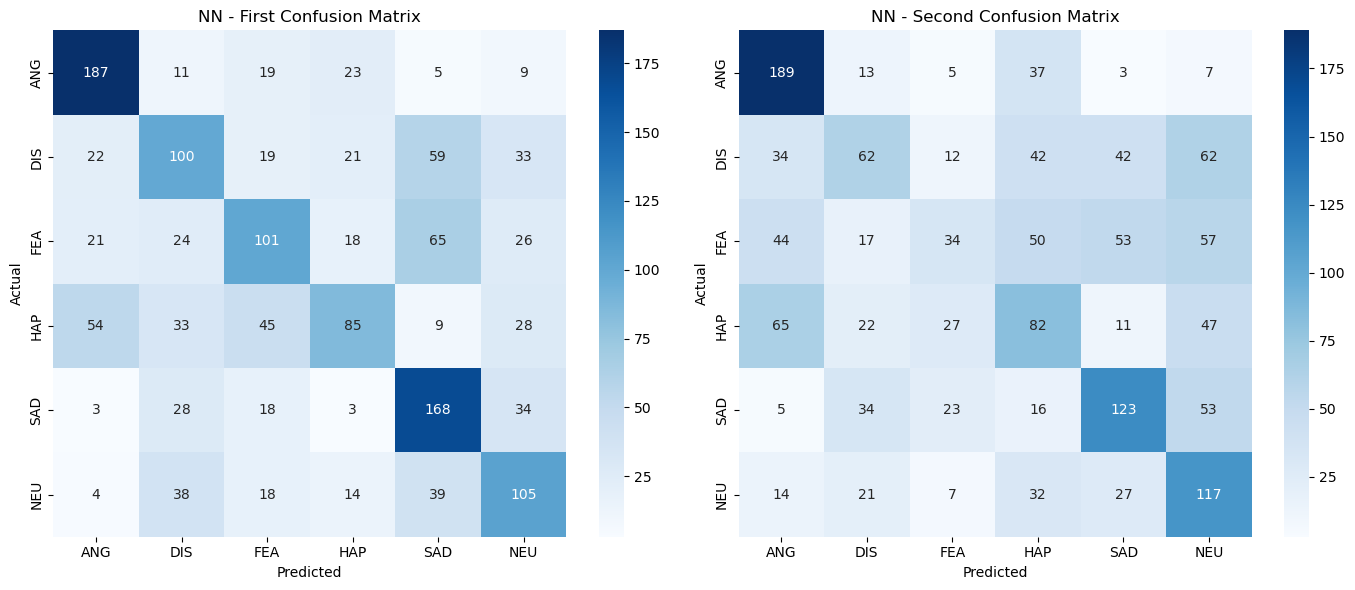

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmnn1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("NN - First Confusion Matrix")

sns.heatmap(cmnn2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("NN - Second Confusion Matrix")

plt.tight_layout()
plt.show()

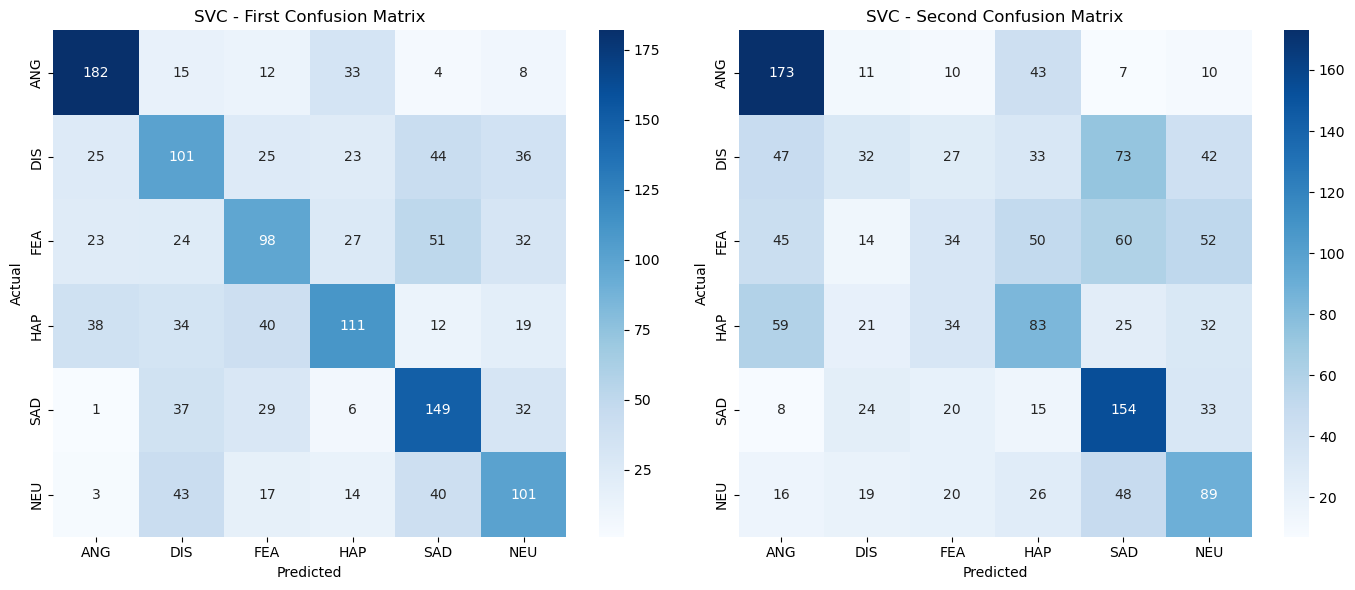

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmsvc1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("SVC - First Confusion Matrix")

sns.heatmap(cmsvc2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("SVC - Second Confusion Matrix")

plt.tight_layout()
plt.show()

Finding optimal parameters for the updated dataset

In [80]:
param_grid = {
    'n_estimators': [100, 150, 200, 220, 250, 270, 300, 305, 310, 320],
}

rf2opt = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf2opt,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_rf2opt = grid_search.best_estimator_
y_pred = best_rf2opt.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'n_estimators': 250}
Best cross-validation score: 0.3679453040662109
Test Accuracy: 0.3875083948959033


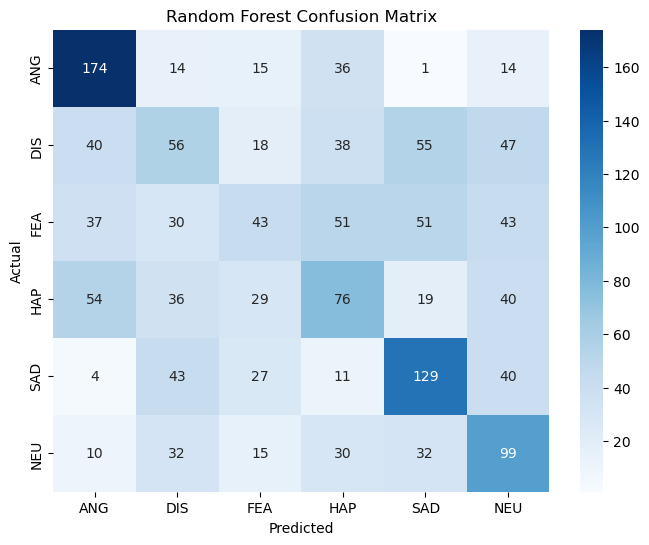

In [81]:
cmrf2opt = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmrf2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

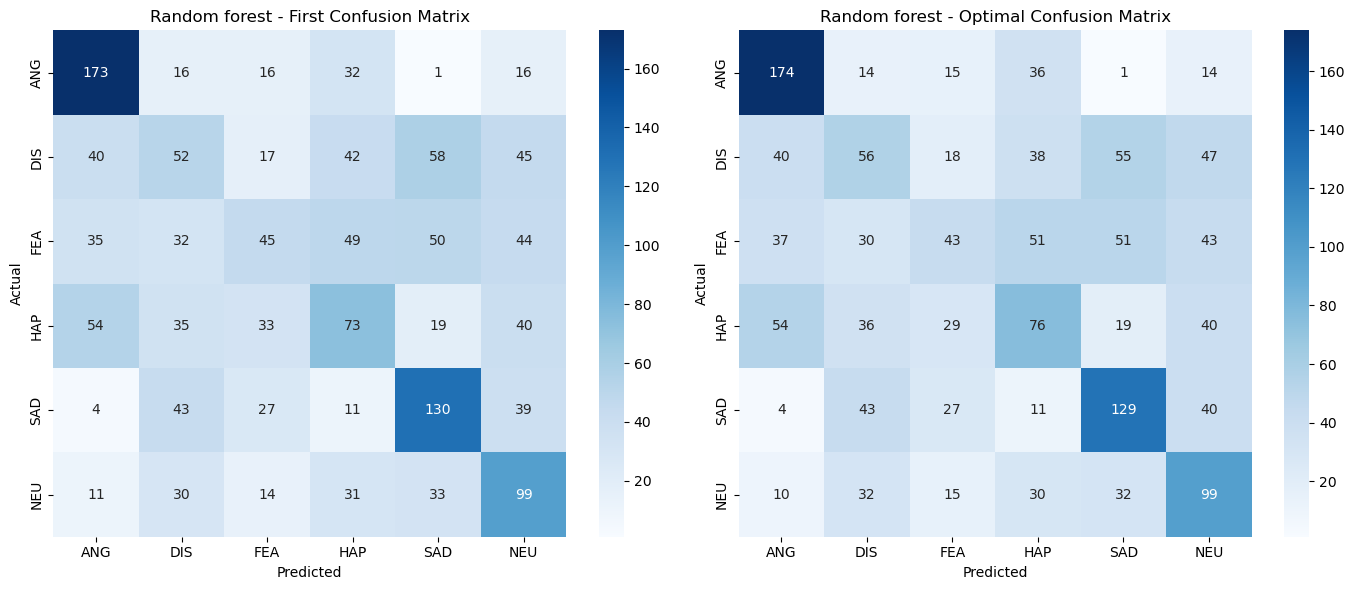

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmrf2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Random forest - First Confusion Matrix")

sns.heatmap(cmrf2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Random forest - Optimal Confusion Matrix")

plt.tight_layout()
plt.show()

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.3803807265979439
Test Accuracy: 0.41638683680322364
              precision    recall  f1-score   support

           0       0.53      0.74      0.61       254
           1       0.37      0.21      0.27       254
           2       0.29      0.15      0.20       255
           3       0.37      0.31      0.34       254
           4       0.46      0.58      0.51       254
           5       0.36      0.52      0.42       218

    accuracy                           0.42      1489
   macro avg       0.40      0.42      0.39      1489
weighted avg       0.40      0.42      0.39      1489



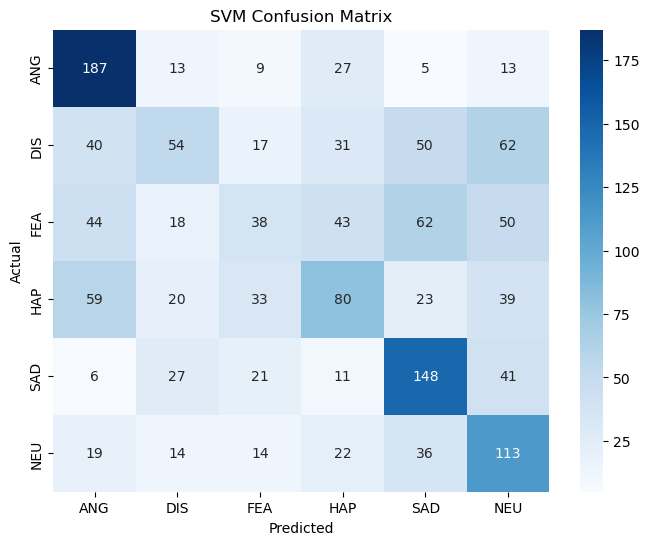

In [84]:
param_grid = {
    'C': [0.1, 1, 5, 10, 15],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']  
}

svc2opt = SVC()

grid_search = GridSearchCV(
    estimator=svc2opt,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_svc2opt = grid_search.best_estimator_
y_pred_svm = best_svc2opt.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc2opt = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

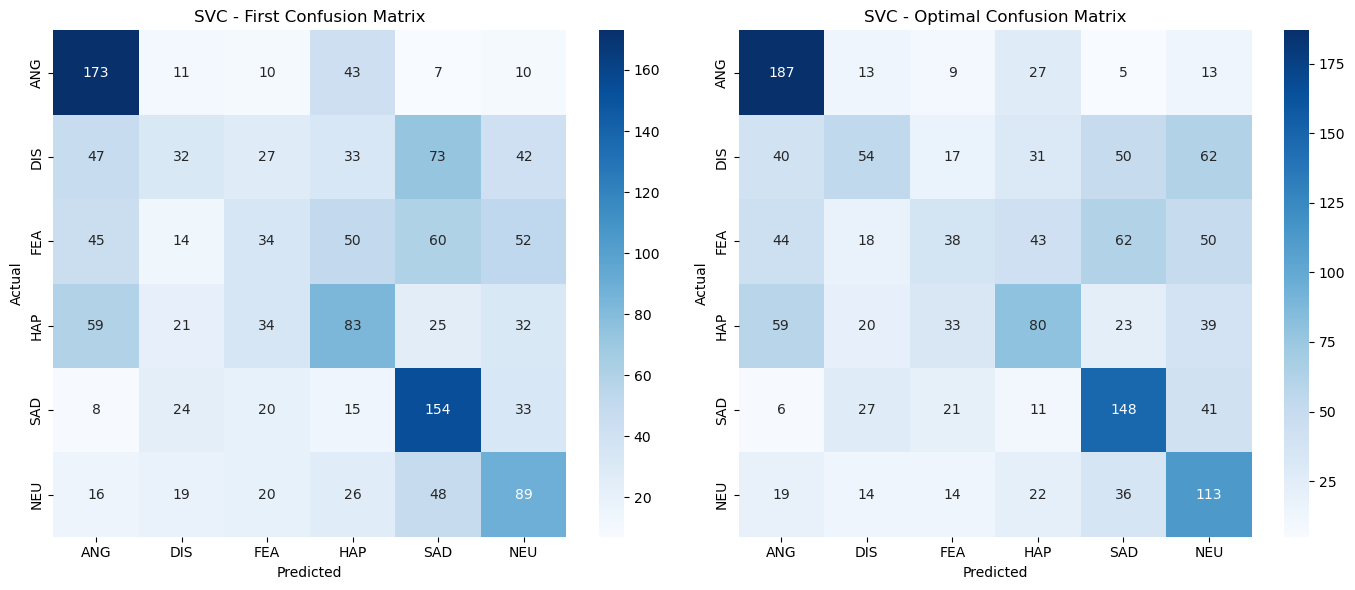

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmsvc2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("SVC - First Confusion Matrix")

sns.heatmap(cmsvc2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("SVC - Optimal Confusion Matrix")

plt.tight_layout()
plt.show()

balancing emotion levels data

In [86]:
df = pd.read_csv('../../dataset/features.csv')

idx = df[df['Emotion levels'] == "X"].index
print(idx)

df = df.drop(idx)

df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['Emotion levels'] = df['Emotion levels'].apply(lambda x: 0 if x == 'XX' else 1)                  #specified/unspecified


emotion_mapping = {
    'ANG': 0,
    'DIS': 1,
    'FEA': 2,
    'HAP': 3,
    'SAD': 4,
    'NEU': 5
}

df['emotion_numeric'] = df['Emotion'].map(emotion_mapping)

df = df.drop(columns=['Emotion'])

list_columns = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean']

for col in list_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


for col in list_columns:
    df[col] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else 0)


numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

numeric_cols = numeric_cols.drop('emotion_numeric') if 'emotion_numeric' in numeric_cols else numeric_cols

print("cols for standardization:", list(numeric_cols))

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\ndata after the standardization process:")
print(df[numeric_cols].head())

df = df.drop(columns=['Location'])

Index([3212], dtype='int64')
cols for standardization: ['Gender', 'Age', 'Emotion levels', 'mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean', 'spectral_centroid_mean', 'zcr_mean']

data after the standardization process:
     Gender       Age  Emotion levels  mfcc_mean  mfcc_delta_mean  \
0  0.945445  1.102698       -0.473977  -1.343910         2.993967   
1  0.945445  1.102698       -0.473977  -1.816883        -0.227654   
2  0.945445  1.102698       -0.473977  -1.760424         0.510616   
3  0.945445  1.102698       -0.473977  -1.652316        -0.769750   
4  0.945445  1.102698       -0.473977  -1.269239         0.743748   

   mfcc_delta2_mean  mel_spec_db_mean  spectral_centroid_mean  zcr_mean  
0         -3.426461         -0.557317                0.491062  0.725741  
1         -0.412230          0.789949                0.260493  0.242048  
2          0.022484         -1.363802                0.119985 -0.024465  
3          1.202826         -0.677227          

Epoch 1/50


C:\Users\milic\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2652 - loss: 1.7079 - val_accuracy: 0.3539 - val_loss: 1.5421
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3385 - loss: 1.5701 - val_accuracy: 0.3741 - val_loss: 1.5106
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3565 - loss: 1.5354 - val_accuracy: 0.3707 - val_loss: 1.5059
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3579 - loss: 1.5291 - val_accuracy: 0.3875 - val_loss: 1.4956
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3872 - loss: 1.4945 - val_accuracy: 0.3868 - val_loss: 1.4871
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3564 - loss: 1.5093 - val_accuracy: 0.3828 - val_loss: 1.4822
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3778 - loss: 1.4780 - val_accuracy: 0.3868 - val_loss: 1.4837
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3730 - loss: 1.4906 - val_accuracy: 0.3828 - val_

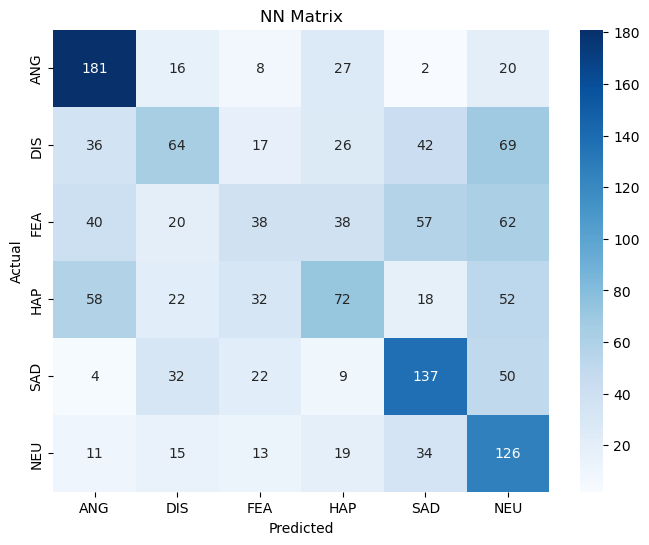

In [88]:
input_dim = X_train.shape[1]  

model3 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nclassification report:\n")
print(classification_report(y_test, y_pred_classes))


cmnn3 = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cmnn3, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NN Matrix")
plt.show()


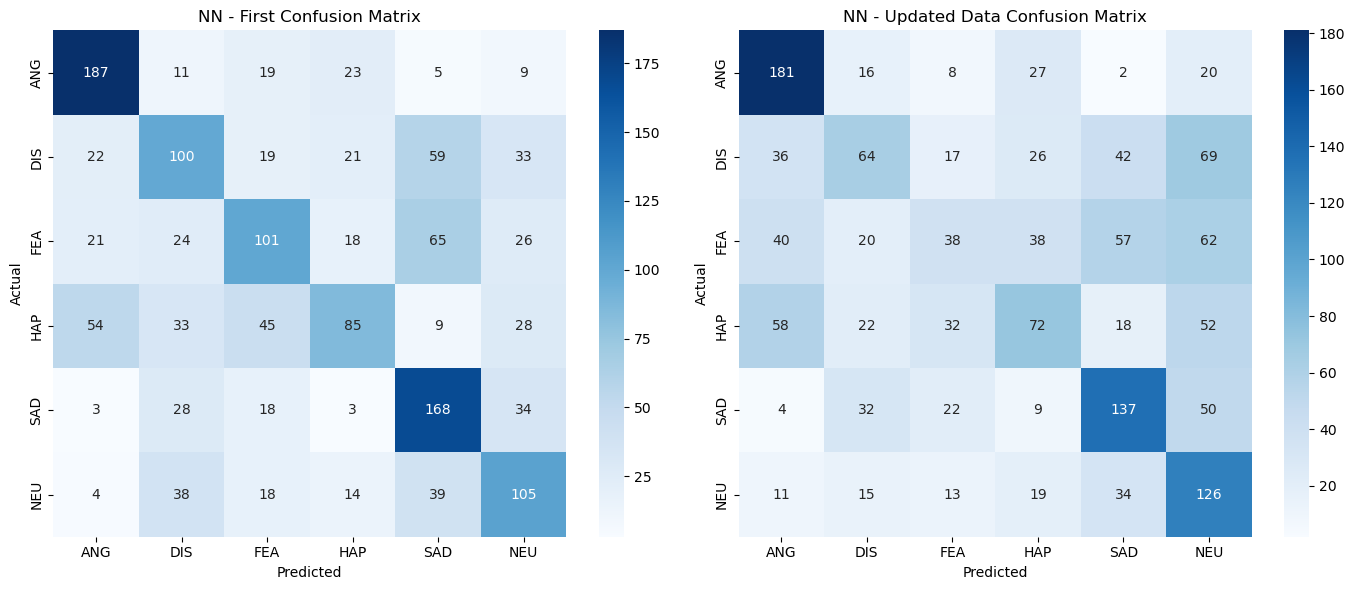

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmnn1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("NN - First Confusion Matrix")

sns.heatmap(cmnn3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("NN - Updated Data Confusion Matrix")

plt.tight_layout()
plt.show()